In [34]:
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import matplotlib.pyplot as plt

In [35]:
def parser(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%d")
    return date_object.strftime("%Y-%m")

In [36]:
def check_stationarity(series):   
    """
    Check stationarity using ADF test
    Ho : The series is non-stationary and has a unit root --> p-value > 0.05
    H1 : The series is stationary and does not have a unit root --> p-value < 0.05
    """
   
    X = series.values
    result = adfuller(X)
    print('Test: Running ADF Stationarity test for {} \n\t ADF test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))

    print('\n\tCritical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
    
    if result[4]['5%'] > result[0]:
        conclusion = 'Series is Stationary @95% CI'
        print ('\t Conclusion: Series is stationary at 95% CI\n')
    elif result[4]['10%'] > result[0]:
        conclusion = 'Series is Stationary @90% CI'
        print ('\t Conclusion: Series is stationary at 90% CI but non-stationary at 95% CI\n')
    else:
        conclusion = 'Series is non-Stationary'
        print ('\t Conclusion: Series is non-stationary\n')
    return conclusion

In [37]:
import pandas as pd 

In [38]:
df = pd.read_csv("./assets/Daten.csv",sep=";" , parse_dates=[0], index_col=0, date_parser=parser).squeeze()
df = df.asfreq(pd.infer_freq(df.index))
df

C:\Users\joshi\AppData\Local\Temp\ipykernel_2068\2250414381.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("./assets/Daten.csv",sep=";" , parse_dates=[0], index_col=0, date_parser=parser).squeeze()


,VSTOXX,VIX,VDAX,Ifo,DE_EPU,Glob_EPU
Datum,,,,,,
2000-01-01,"28,94837619","23,202","31,4","96,2","73,23399039","63,36971598"
2000-02-01,"30,04859048","23,5955","28,54","97,8","97,3584286","58,69227896"
2000-03-01,"28,53686522","22,71826087","26,84",97,"96,09150486","60,83247665"
2000-04-01,"28,53848333","27,16421053","23,7","98,2","69,44795177","64,23391535"
2000-05-01,"27,94932727","26,37318182","23,67","98,3","135,287133","86,54617843"
...,...,...,...,...,...,...
2023-11-01,"15,16474545","14,01909091","14,52727273","86,4","626,1370391","246,8767661"
2023-12-01,"13,40822632","12,7185","13,35421053","84,9","672,5178656","255,8841805"
2024-01-01,"14,08706364","13,38863636","13,86409091","84,6","729,8969081","229,2457779"


In [39]:
# Fehlende Wert Nan rows
df = df.dropna()
#change , to .
df = df.replace({',': '.'}, regex=True)
df = df[df.index.year != 2024]
df

,VSTOXX,VIX,VDAX,Ifo,DE_EPU,Glob_EPU
Datum,,,,,,
2000-01-01,28.94837619,23.202,31.4,96.2,73.23399039,63.36971598
2000-02-01,30.04859048,23.5955,28.54,97.8,97.3584286,58.69227896
2000-03-01,28.53686522,22.71826087,26.84,97,96.09150486,60.83247665
2000-04-01,28.53848333,27.16421053,23.7,98.2,69.44795177,64.23391535
2000-05-01,27.94932727,26.37318182,23.67,98.3,135.287133,86.54617843
...,...,...,...,...,...,...
2023-08-01,18.54876957,15.85391304,17.44913043,85.7,661.2609143,211.1258178
2023-09-01,16.87085238,15.17333333,15.71904762,85.7,737.6819317,243.8861011
2023-10-01,20.23206818,18.88772727,19.10272727,85.5,669.56517,226.1056601


In [40]:
#### check if series
print(df.VSTOXX)
type(df.VSTOXX)

Datum
2000-01-01    28.94837619
2000-02-01    30.04859048
2000-03-01    28.53686522
2000-04-01    28.53848333
2000-05-01    27.94932727
                 ...     
2023-08-01    18.54876957
2023-09-01    16.87085238
2023-10-01    20.23206818
2023-11-01    15.16474545
2023-12-01    13.40822632
Freq: MS, Name: VSTOXX, Length: 288, dtype: object


pandas.core.series.Series

In [41]:
series_vstoxx = df.VSTOXX
series_vix = df.VIX
series_vdax = df.VDAX
series_ifo = df.Ifo
series_de_epu = df.DE_EPU
series_glob_epu = df.Glob_EPU

series_vstoxx = series_vstoxx.astype(float)
series_vix = series_vix.astype(float)
series_vdax = series_vdax.astype(float)
series_ifo = series_ifo.astype(float)
series_de_epu = series_de_epu.astype(float)
series_glob_epu = series_glob_epu.astype(float)



In [42]:
series_vstoxx[0]

C:\Users\joshi\AppData\Local\Temp\ipykernel_2068\3431158709.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  series_vstoxx[0]


28.94837619

In [43]:
check_stationarity(series=series_vstoxx)

Test: Running ADF Stationarity test for VSTOXX 
	 ADF test statistic: -3.7085921688140724 
	 p-value: 0.0039939080274051676 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI



'Series is Stationary @95% CI'

In [44]:
check_stationarity(series=series_vix)
check_stationarity(series=series_de_epu)
check_stationarity(series=series_vdax)
check_stationarity(series=series_glob_epu)
check_stationarity(series=series_ifo)

Test: Running ADF Stationarity test for VIX 
	 ADF test statistic: -4.304555397145242 
	 p-value: 0.000436212501729611 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for DE_EPU 
	 ADF test statistic: -1.065469559022073 
	 p-value: 0.7286440416712561 

	Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is non-stationary

Test: Running ADF Stationarity test for VDAX 
	 ADF test statistic: -4.769348929168181 
	 p-value: 6.222442676861572e-05 

	Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is stationary at 95% CI

Test: Running ADF Stationarity test for Glob_EPU 
	 ADF test statistic: -0.6922793697606332 
	 p-value: 0.848739232332693 

	Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
	 Conclusion: Series is non-stationary

Test: Running ADF Stationarity test for Ifo 
	 ADF test statistic: -3.0392105484547574 
	 p-value: 0.03139136140489031

'Series is Stationary @95% CI'

In [45]:
def series_standardization(series) -> pd.Series:
    avg, dev = series.mean(), series.std()
    standardized_series = (series - avg) / dev
    return standardized_series

In [46]:
# Normalisieren de epu zeitreihe
series_de_epu_norm = series_standardization(series=series_de_epu)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')


In [47]:
# Normalisieren global epu zeitreihe
series_global_epu_norm = series_standardization(series=series_glob_epu)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')


In [48]:
# Normalisieren  Ifo zeitreihe
series_ifo_norm = series_standardization(series=series_ifo)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')


In [49]:
# Normalisieren  VDax zeitreihe
series_vdax_norm = series_standardization(series=series_vdax)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')


In [50]:
# Normalisieren  VIX zeitreihe
series_vix_norm = series_standardization(series=series_vix)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')

In [51]:
# Normalisieren  Vstoxx zeitreihe
series_vstoxx_norm = series_standardization(series=series_vstoxx)
# plt.figure(figsize=(12,6))
# plt.plot(series_de_epu_norm, color='red')

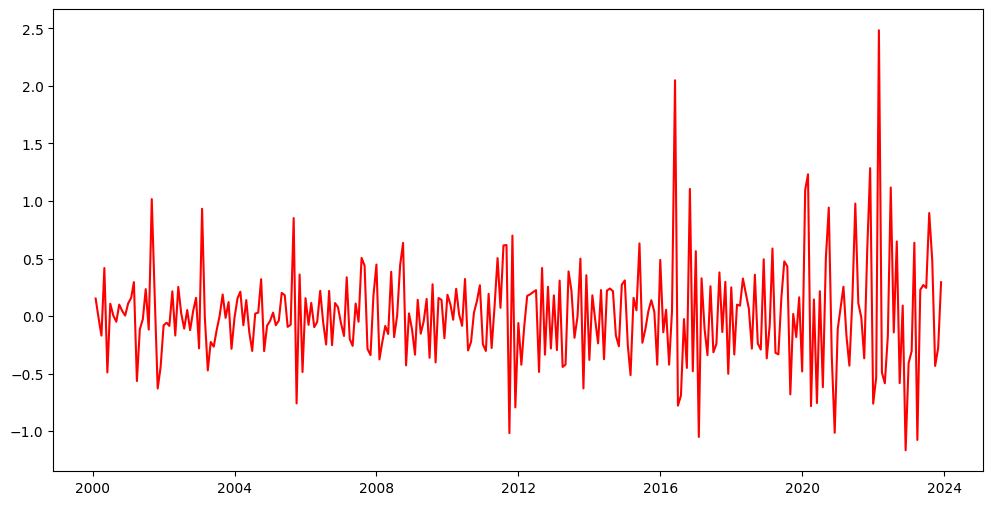

In [52]:
# remove trend trough calculating the
# differences of the Series elements (default is element in previous row).

series_de_epu_norm_trendremoved = series_de_epu_norm.diff()
plt.figure(figsize=(12,6))
plt.plot(series_de_epu_norm_trendremoved, color='red')

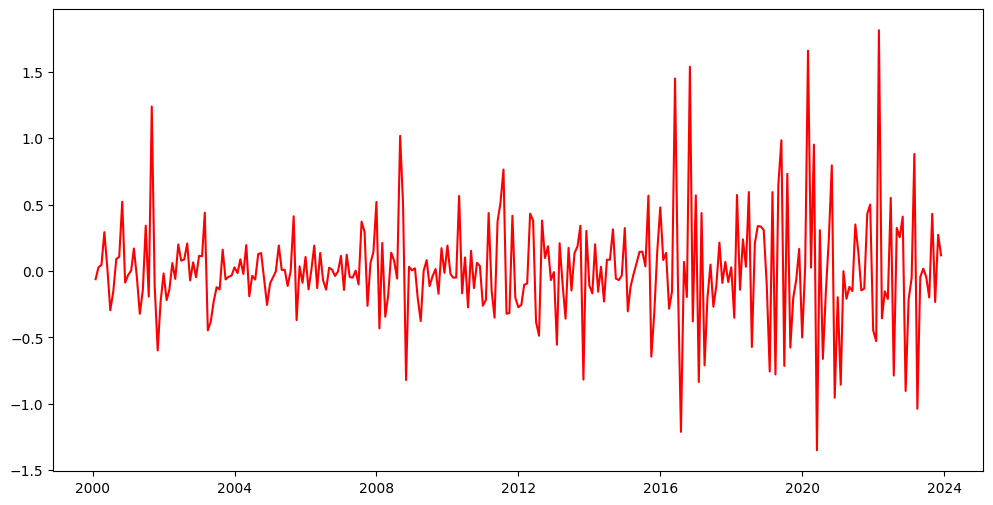

In [53]:
series_global_epu_norm_trendremoved = series_global_epu_norm.diff()
plt.figure(figsize=(12,6))
plt.plot(series_global_epu_norm_trendremoved, color='red')

### Remove Incr. Vola

In [54]:
series_global_epu_norm_trendremoved

Datum
2000-01-01         NaN
2000-02-01   -0.061363
2000-03-01    0.028077
2000-04-01    0.044623
2000-05-01    0.292712
                ...   
2023-08-01   -0.199193
2023-09-01    0.429778
2023-10-01   -0.233259
2023-11-01    0.272494
2023-12-01    0.118167
Freq: MS, Name: Glob_EPU, Length: 288, dtype: float64

In [55]:
## DE_Epu weitermachen
def remove_increasing_vola(series):
    annual_volatility = series.groupby(series.index.year).std()
    series_annual_volatility = series.index.map(lambda d: annual_volatility.loc[d.year])
    series = series / series_annual_volatility
    return series


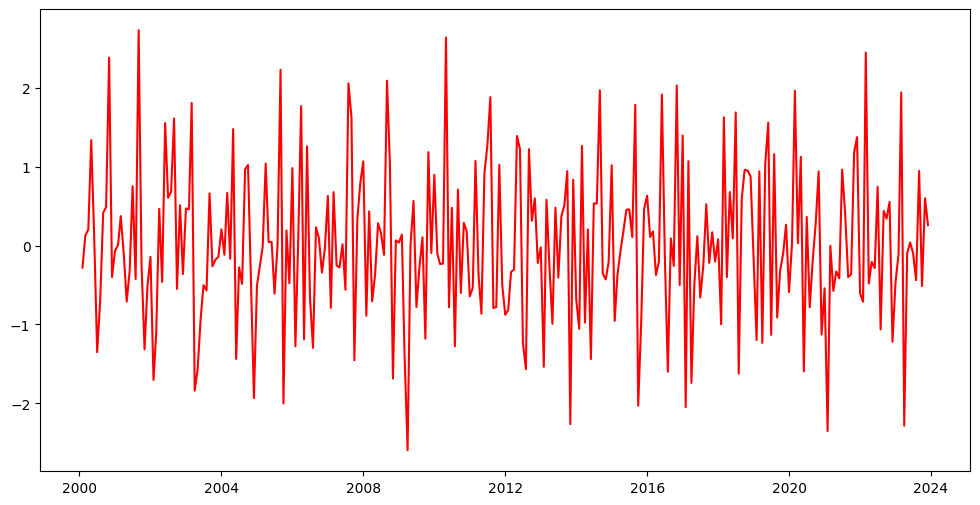

In [56]:
series_global_epu_norm_trendremoved = remove_increasing_vola(series_global_epu_norm_trendremoved)

plt.figure(figsize=(12,6))
plt.plot(series_global_epu_norm_trendremoved, color='red')

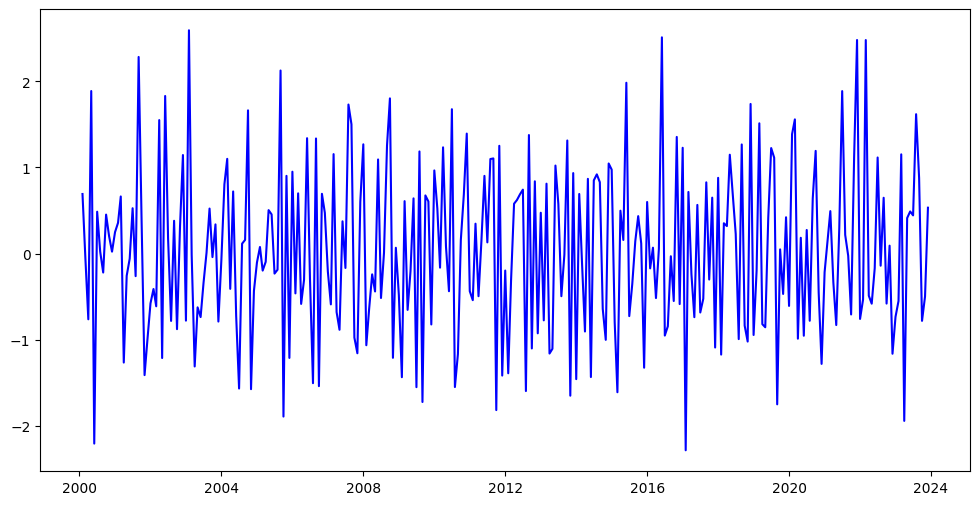

In [57]:
series_de_epu_norm_trendremoved = remove_increasing_vola(series_de_epu_norm_trendremoved)

plt.figure(figsize=(12,6))
plt.plot(series_de_epu_norm_trendremoved, color='blue')

## Remove Seasonality

In [ ]:
month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()
print(month_avgs)

ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])


ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']

### PACF

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf()
plt.show()

TypeError: plot_pacf() missing 1 required positional argument: 'x'

## VAR 